In [1]:
%load_ext autoreload
%autoreload 2


In [96]:
import itertools
import json
import os

import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial
import seaborn as sns
import sklearn
import torch
import tqdm
import umap

import celltrip


mpl.rcParams['pdf.fonttype'] = 42


# Load Data and Policy

In [ ]:
# Read data files
# adata_prefix = 's3://nkalafut-celltrip/Dyngen'
adata_prefix = '../data/Dyngen'
adatas = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/dyngen/logcounts.h5ad',
    's3://nkalafut-celltrip/dyngen/counts_protein.h5ad',
    backed=True)
# Model location and name (should be prefix for .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Dyngen-250920', 800  # 8 dim
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Dyngen-251015', 800  # 32 dim - USED, doesn't log-transform protein
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Dyngen-251025', 800  # 32 dim, extra feature processing hidden layer
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
adatas[0].obs['Training'] = mask
# Create sample env (kind of a dumb workaround, TODO)
m1, m2 = [preprocessing.transform(ad[:2].X, subset_modality=i)[0] for i, ad in enumerate(adatas)]
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), compute_rewards=False, dim=32).eval().to('cuda')
# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


# Get Steady State

In [62]:
m1, m2 = [preprocessing.transform(ad.X[:], subset_modality=i)[0] for i, ad in enumerate(adatas)]
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), compute_rewards=False, dim=32).eval(time_scale=1).to('cuda')
ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
steady_state = ret[-1][-1, :, :env.dim]

# GEX
with torch.no_grad():
    pinned_steady_state_0 = policy.pinning[0](steady_state.to('cuda')).detach().cpu().numpy()
imputed_steady_state_0, = preprocessing.inverse_transform(pinned_steady_state_0, subset_modality=0)

# Protein
with torch.no_grad():
    pinned_steady_state_1 = policy.pinning[1](steady_state.to('cuda')).detach().cpu().numpy()
imputed_steady_state_1, = preprocessing.inverse_transform(pinned_steady_state_1, subset_modality=1)

1280it [00:07, 176.68it/s]


## Compare Methods

In [79]:
# Save for running other methods
d1, d2 = [ad.X[:].toarray() for ad in adatas]
mask = adatas[0].obs['Training'].to_numpy()
np.save('../plots/dyngen/dyngen_logcounts.npy', d1)
np.save('../plots/dyngen/dyngen_protein.npy', d2)
np.save('../plots/dyngen/dyngen_logcounts_pre.npy', m1)
np.save('../plots/dyngen/dyngen_protein_pre.npy', m2)
np.save('../plots/dyngen/dyngen_mask.npy', mask)

In [ ]:
# Load methods
methods = ('scScope', 'JAMIE', 'PCA', 'Autoencoder')
reconstructions = {}
reconstructions['Original'] = {}
reconstructions['Original']['logcounts'] = d1
reconstructions['Original']['protein'] = d2
# reconstructions['Original']['logcounts'] = m1
# reconstructions['Original']['protein'] = m2
reconstructions['CellTRIP'] = {}
reconstructions['CellTRIP']['logcounts'] = imputed_steady_state_0
reconstructions['CellTRIP']['protein'] = imputed_steady_state_1
# reconstructions['CellTRIP']['logcounts'] = pinned_steady_state_0
# reconstructions['CellTRIP']['protein'] = pinned_steady_state_1
for method in methods:
    reconstructions[method] = {}
    reconstructions[method]['logcounts'] = np.load(f'../plots/dyngen/{method}_logcounts.npy')
    reconstructions[method]['protein'] = np.load(f'../plots/dyngen/{method}_protein.npy')
    # reconstructions[method]['logcounts'] = np.load(f'../plots/dyngen/{method}_logcounts_pre.npy')
    # reconstructions[method]['protein'] = np.load(f'../plots/dyngen/{method}_protein_pre.npy')


In [283]:
# Comparison metrics
def compute_lta(pred, orig, labels, *args, **kwargs):
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')
    knn.fit(orig, labels)
    return (knn.predict(pred) == labels).mean()
def compute_mse(pred, orig, *args, **kwargs):
    return np.square(orig - pred).mean()
def compute_pairwise_mse(pred, orig, *args, **kwargs):
    pred_dist = scipy.spatial.distance.pdist(pred, 'euclidean')
    orig_dist = scipy.spatial.distance.pdist(orig, 'euclidean')
    return np.square(orig_dist - pred_dist).mean()

# Compute accuracies
traj = adatas[0].obs['traj_sim'].to_numpy()
results = []
for method, modality in itertools.product(list(reconstructions.keys()), ('logcounts', 'protein')):
    if method == 'Original': continue
    # Load data
    pred = reconstructions[method][modality][~mask]
    orig = reconstructions['Original'][modality][~mask]
    # Log modality
    if modality == 'protein':
        orig, pred = orig.copy(), pred.copy()
        pred[pred < 0] = 0
        orig = np.log1p(orig)
        pred = np.log1p(pred)
    # Labels
    labels = traj[~mask]
    # Run metrics
    lta = compute_lta(pred, orig, labels)
    mse = compute_mse(pred, orig, labels)
    pairwise_mse = compute_pairwise_mse(pred, orig, labels)
    # Record
    results.append({
        'Method': method,
        'Modality': modality,
        'LTA': lta,
        'MSE': mse,
        'Pairwise MSE': pairwise_mse})
results = pd.DataFrame(results)

In [287]:
results.sort_values('LTA', ascending=False).groupby('Modality').head(10)

,Method,Modality,LTA,MSE,Pairwise MSE
7,PCA,protein,0.798046,4.612666,478.873163
5,JAMIE,protein,0.771987,4.431828,1108.373408
9,Autoencoder,protein,0.758958,6.844228,340.957809
1,CellTRIP,protein,0.410423,8.606744,1287.617477
0,CellTRIP,logcounts,0.247557,0.160214,221.192026
3,scScope,protein,0.231270,27.317963,3836.225535
4,JAMIE,logcounts,0.214984,0.109087,309.691048
6,PCA,logcounts,0.195440,0.130335,337.407133
2,scScope,logcounts,0.130293,0.907762,210.532805
8,Autoencoder,logcounts,0.123779,0.149536,717.190399


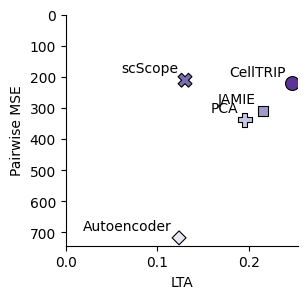

In [286]:
# Plot GEX performance
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
x_var, y_var = 'LTA', 'Pairwise MSE'
modality = 'logcounts'
sns.scatterplot(
    results.loc[results['Modality']==modality], x=x_var, y=y_var, hue='Method', hue_order=list(reconstructions.keys())[1:],
    style='Method', palette='Purples_r', edgecolor='black', s=100, legend=False, ax=ax)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.invert_yaxis()
for method in list(reconstructions.keys())[1:]:
    row = results.loc[(results['Method']==method)*(results['Modality']==modality)]
    data_to_axis = ax.transData + ax.transAxes.inverted()
    x, y = data_to_axis.transform([row[x_var], row[y_var]]).flatten()
    ax.text(x-.03, y+.02, method, ha='right', va='bottom', transform=ax.transAxes)
sns.despine(ax=ax)
fig.savefig('../plots/dyngen/Reconstruction_Comparison.pdf')

## Preview

In [5]:
# # Generate data GEX
# X0 = adatas[0].X[:]
# X0_pred = imputed_steady_state_0
# red = umap.UMAP()  # random_state=42
# Y0 = red.fit_transform(X0)
# Y0_pred = red.transform(X0_pred)

# # Generate data protein
# X1 = adatas[1].X[:]
# X1_pred = imputed_steady_state_1
# red = umap.UMAP()  # random_state=42
# Y1 = red.fit_transform(X1)
# Y1_pred = red.transform(X1_pred)

# # Plot figure
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# for i, j in itertools.product(*[np.arange(2) for _ in range(2)]):
#     # Get axis
#     ax = axs[i, j]

#     # Get data
#     df = pd.DataFrame(index=adatas[0].obs_names)
#     df[['x', 'y']] = [Y0, Y0_pred, Y1, Y1_pred][2*i+j]
#     df['Trajectory'] = adatas[0].obs['traj_sim']
#     df['Validation'] = ~adatas[0].obs['Training']

#     # Plot
#     legend = (i==0)*(j==1)
#     sns.scatterplot(df, x='x', y='y', hue='Trajectory', style='Validation', edgecolor='black', legend=legend, ax=ax)
#     if legend: sns.move_legend(ax, 'upper left', bbox_to_anchor=(1.05, 1))

#     # Format
#     ax.set(xlabel=None, ylabel=None)
#     sns.despine(ax=ax)
#     if j == 1:
#         # Set xlim
#         ax_alt = axs[i, 0]
#         ax_alt_xlim = ax_alt.get_xlim()
#         ax_xlim = ax.get_xlim()
#         xlim = np.stack([ax_xlim, ax_alt_xlim], axis=0).max(axis=0)
#         ax.set_xlim(xlim)
        
#         # Set ylim
#         ax_alt = axs[i, 0]
#         ax_alt_ylim = ax_alt.get_ylim()
#         ax_ylim = ax.get_ylim()
#         ylim = np.stack([ax_ylim, ax_alt_ylim], axis=0).max(axis=0)
#         ax.set_ylim(ylim)

#     # Title
#     if i == 0:
#         if j == 0: ax.set_title('Observed')
#         if j == 1: ax.set_title('Reconstructed')
#     if j == 0:
#         if i == 0: ax.set_ylabel('Gene Expression', fontsize='large')
#         if i == 1: ax.set_ylabel('Protein Counts', fontsize='large')


# Compare Knockdown to Real

In [9]:
# Load KO data
adata_ko, = celltrip.utility.processing.read_adatas('../plots/dyngen/Dyngen_KO_D8.h5ad', backed=True)
original_counts, original_protein = adatas[0].X[:].todense(), adatas[1].X[:].todense()
original_counts, original_protein = np.array(original_counts), np.array(original_protein)
actual_counts, actual_protein = np.array(adata_ko.layers['logcounts'].todense()), np.array(adata_ko.layers['counts_protein'].todense())
actual_counts, actual_protein = np.array(actual_counts), np.array(actual_protein)
# actual_counts, actual_protein = preprocessing.transform([np.array(adata_ko.layers['logcounts'].todense()), np.array(adata_ko.layers['counts_protein'].todense())])

In [10]:
## Compute steady state
# Load regular data
m1, m2 = preprocessing.transform([original_counts, original_protein])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), compute_rewards=False, dim=32).eval(time_scale=5).to('cuda')

# Simulate
ret = celltrip.train.simulate_until_completion(
    env, policy, skip_states=100, store_states='cpu', progress_bar=True)
original_steady_state_full = ret[-1][-1]
original_steady_state = original_steady_state_full[..., :env.dim]

# GEX
with torch.no_grad():
    original_imp_counts = policy.pinning[0](original_steady_state.to('cuda')).detach().cpu().numpy()
original_imp_counts, = preprocessing.inverse_transform(original_imp_counts, subset_modality=0)

# Protein
with torch.no_grad():
    original_imp_protein = policy.pinning[1](original_steady_state.to('cuda')).detach().cpu().numpy()
original_imp_protein, = preprocessing.inverse_transform(original_imp_protein, subset_modality=1)

6400it [00:36, 174.51it/s]


In [ ]:
# adatas[0].var.loc[adatas[0].var['module_id'] == 'F1']
# adatas[0].var['module_ct'] = adatas[0].var['module_id'].apply(lambda s: s[:-1])
# filt_df = adatas[0].var.groupby('module_id').first().reset_index()
# filt_df.groupby('module_ct', observed=True).size().reset_index()  # 5 - 14 - counting # of genes
# adatas[0].var.groupby('module_id', observed=True).size().reset_index().iloc[:10]

,module_id,basal,burn,independence,color,is_tf,is_hk,transcription_rate,splicing_rate,translation_rate,mrna_halflife,protein_halflife,mrna_decay_rate,protein_decay_rate,max_premrna,max_mrna,max_protein,mol_premrna,mol_mrna,mol_protein
F1_TF1,F1,0.0,False,1.0,#CC99FF,True,False,19.345321,0.346574,137.751385,2.552675,6.241972,0.271538,0.111046,31.29748,39.946153,49552.694518,mol_premrna_F1_TF1,mol_mrna_F1_TF1,mol_protein_F1_TF1


In [30]:
## Compute knockdown
# Get knockdown gene
gene_idx = np.argwhere(adatas[1].var['module_id'] == 'D8').flatten()
feature_targets_counts = actual_counts[:, gene_idx].mean(axis=0)
feature_targets_protein = actual_protein[:, gene_idx].mean(axis=0)

# Simulate
env.reset().set_max_time(128.)
env.set_state(original_steady_state_full.to('cuda'))
ret = celltrip.train.simulate_until_completion(
    env, policy,
    env_hooks=[
        celltrip.utility.hooks.clamp_inverted_features_hook(  # Gene
            gene_idx, preprocessing, feature_targets=feature_targets_counts, modality_idx=0),
        celltrip.utility.hooks.clamp_inverted_features_hook(  # Protein
            gene_idx, preprocessing, feature_targets=feature_targets_protein, modality_idx=1)
    ],
    action_hooks=[
        celltrip.utility.hooks.move_toward_targets_hook(  # Gene
            gene_idx, feature_targets=feature_targets_counts, pinning=policy.pinning[0],
            preprocessing=preprocessing, modality_idx=0,
            factor=1, device=env.device),
        celltrip.utility.hooks.move_toward_targets_hook(  # Protein
            gene_idx, feature_targets=feature_targets_protein, pinning=policy.pinning[0],
            preprocessing=preprocessing, modality_idx=1,
            factor=1, device=env.device)
    ],
    skip_states=100, store_states='cpu', progress_bar=True)
knocked_steady_state = ret[-1][-1, :, :env.dim]

# GEX
with torch.no_grad():
    knocked_imp_counts = policy.pinning[0](knocked_steady_state.to('cuda')).detach().cpu().numpy()
knocked_imp_counts, = preprocessing.inverse_transform(knocked_imp_counts, subset_modality=0)

# Protein
with torch.no_grad():
    knocked_imp_protein = policy.pinning[1](knocked_steady_state.to('cuda')).detach().cpu().numpy()
knocked_imp_protein, = preprocessing.inverse_transform(knocked_imp_protein, subset_modality=1)

1280it [00:26, 48.98it/s]


In [31]:
with torch.no_grad():
    knocked_imp_counts_base = policy.pinning[0](ret[-1][1, :, :env.dim].to('cuda')).detach().cpu().numpy()
knocked_imp_counts_base, = preprocessing.inverse_transform(knocked_imp_counts_base, subset_modality=0)

In [32]:
# Compute HVGs
hvg_idx = original_counts.var(axis=0).argsort()[::-1][:]  # [:200]

# Calculate ground truth
actual_diff = actual_counts.mean(axis=0) - original_counts.mean(axis=0)

# Calculate predicted
knocked_diff = knocked_imp_counts.mean(axis=0) - original_imp_counts.mean(axis=0)
knocked_diff = knocked_imp_counts.mean(axis=0) - knocked_imp_counts_base.mean(axis=0)

# Get correlation
np.corrcoef(np.stack([actual_diff[hvg_idx], knocked_diff[hvg_idx]]))[0, 1]

np.float64(-0.0035471245748292957)

# Perform Significance Estimation

In [ ]:
# Params
np.random.seed(42)
genes_to_survey = adatas[0].var_names
sim_time = 1.

# Mute warnings (array wrap and indexing)
import warnings
warnings.simplefilter('ignore')

# Create anndata
ad_pert = ad.AnnData(obs=adatas[0].obs, var=pd.DataFrame(index=[f'Feature {i}' for i in range(env.dim)]))
# ad_pert0 = ad.AnnData(obs=adatas[0].obs, var=adatas[0].var)
# ad_pert1 = ad.AnnData(obs=adatas[1].obs, var=adatas[1].var)
def add_layers(states, gene):
    ad_pert.layers[gene] = states
    # ad_pert0.layers[gene] = states_0
    # ad_pert1.layers[gene] = states_1

# Add results
results = []
def add_record(states, states_0, states_1, gene, ct):
    results.append({
        'Gene': gene, 'Cell Type': ct,
        'Effect Size (Latent)': np.sqrt(np.square(states[-1] - states[0]).sum(axis=-1)).mean(),
        'Trajectory Length (Latent)': np.sqrt(np.square(states[1:] - states[:-1])).mean(axis=-1).sum(),
        'Effect Size (Modality 0)': np.sqrt(np.square(states_0[-1] - states_0[0]).sum(axis=-1)).mean(),
        'Trajectory Length (Modality 0)': np.sqrt(np.square(states_0[1:] - states_0[:-1])).mean(axis=-1).sum(),
        'Effect Size (Modality 1)': np.sqrt(np.square(states_1[-1] - states_1[0]).sum(axis=-1)).mean(),
        'Trajectory Length (Modality 1)': np.sqrt(np.square(states_1[1:] - states_1[:-1])).mean(axis=-1).sum()})
    
# Reset function
def reset_env(env, steady_pos, steady_vel, modal_dict={}):
    env.set_max_time(sim_time).reset()  # TODO: Maybe longer?, early stopping?
    env.set_positions(steady_pos)
    env.set_velocities(steady_vel)  # Maybe 0 manually?
    for k, v in modal_dict.items():
        env.modalities[k] = v

# Running function
def run_and_record(samples, env, policy, preprocessing, gene, gene_idx):
    # Run and impute
    states = celltrip.train.simulate_until_completion(
        env, policy,
        env_hooks=[
            celltrip.utility.hooks.clamp_inverted_features_hook(
                gene_idx, preprocessing, feature_targets=0., modality_idx=0),
        ],
        action_hooks=[
            celltrip.utility.hooks.move_toward_targets_hook(
                gene_idx, feature_targets=0., pinning=policy.pinning[0],
                preprocessing=preprocessing, modality_idx=0,
                factor=1, device=env.device),
        ],
        store_states='cpu')[-1]
    states_pos = states[..., :env.dim]
    with torch.no_grad():
        imputed_states_0 = policy.pinning[0](states_pos.to('cuda')).detach().cpu().numpy()
        imputed_states_1 = policy.pinning[1](states_pos.to('cuda')).detach().cpu().numpy()
    imputed_states_0, = preprocessing.inverse_transform(imputed_states_0, subset_modality=0)
    imputed_states_1, = preprocessing.inverse_transform(imputed_states_1, subset_modality=1)
    # Record
    add_layers(states_pos.numpy()[-1], gene)  # , imputed_states_0[-1], imputed_states_1[-1]
    add_record(states_pos.numpy(), imputed_states_0, imputed_states_1, gene, 'All')
    for ct in adatas[0][samples].obs['traj_sim'].unique():
        add_record(
            states_pos[:, adatas[0][samples].obs['traj_sim']==ct].numpy(),
            imputed_states_0[:, adatas[0][samples].obs['traj_sim']==ct],
            imputed_states_1[:, adatas[0][samples].obs['traj_sim']==ct],
            gene, ct)

# Subset and preprocess the data
samples = adatas[0].obs.index
raw_m1 = celltrip.utility.processing.chunk_X(adatas[0][samples], chunk_size=2_000)
m1, m2 = [
    celltrip.utility.processing.chunk_X(
        ad[samples], chunk_size=2_000,
        func=lambda x: preprocessing.transform(x, subset_modality=i)[0])
        for i, ad in enumerate(adatas)]

# Initialize environment
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), compute_rewards=False, dim=env.dim).eval(time_scale=1).to('cuda')

# Simulate to steady state
env.reset()
celltrip.train.simulate_until_completion(env, policy)
steady_pos, steady_vel = (env.pos, env.vel)

# Run control
reset_env(env, steady_pos, steady_vel)
add_layers(steady_pos.cpu().numpy(), 'Steady')
run_and_record(samples, env, policy, preprocessing, 'Control', [])

# Perturb
for gene in tqdm.tqdm(genes_to_survey, miniters=10, maxinterval=30):
    # Get gene idx and run
    gene_idx = np.argwhere(adatas[0].var_names==gene).flatten()
    reset_env(env, steady_pos, steady_vel)  # {0: torch.tensor(m1).cuda()}
    run_and_record(samples, env, policy, preprocessing, gene, gene_idx)

# Convert and save
pd.DataFrame(results).to_csv('../plots/dyngen/knockdown.csv', index=None)
ad_pert.write_h5ad('../plots/dyngen/knockdown_results.h5ad')
# ad_pert0.write_h5ad('../plots/dyngen/knockdown_results_modality_0.csv')
# ad_pert1.write_h5ad('../plots/dyngen/knockdown_results_modality_1.csv')



  0%|                                                                                                                                                                                             | 0/2400 [00:00<?, ?it/s]


  0%|▋                                                                                                                                                                                 | 10/2400 [00:21<1:23:56,  2.11s/it]


  1%|█▍                                                                                                                                                                                | 20/2400 [00:44<1:28:16,  2.23s/it]


  1%|██▏                                                                                                                                                                               | 30/2400 [01:06<1:28:18,  2.24s/it]


  2%|██▉                                                                                                                                                                               | 40/2400 [01:26<1:24:01,  2.14s/it]


  2%|███▋                                                                                                                                                                              | 50/2400 [01:44<1:19:38,  2.03s/it]


  2%|████▍                                                                                                                                                                             | 60/2400 [02:06<1:20:21,  2.06s/it]


  3%|█████▏                                                                                                                                                                            | 70/2400 [02:31<1:26:01,  2.22s/it]


  3%|█████▉                                                                                                                                                                            | 80/2400 [02:52<1:24:51,  2.19s/it]


  4%|██████▋                                                                                                                                                                           | 90/2400 [03:13<1:22:22,  2.14s/it]


  4%|███████▍                                                                                                                                                                         | 100/2400 [03:32<1:20:00,  2.09s/it]


  5%|████████                                                                                                                                                                         | 110/2400 [03:51<1:16:45,  2.01s/it]


  5%|████████▊                                                                                                                                                                        | 120/2400 [04:09<1:14:19,  1.96s/it]


  5%|█████████▌                                                                                                                                                                       | 130/2400 [04:29<1:14:26,  1.97s/it]


  6%|██████████▎                                                                                                                                                                      | 140/2400 [04:48<1:13:09,  1.94s/it]


  6%|███████████                                                                                                                                                                      | 150/2400 [05:07<1:12:14,  1.93s/it]


  7%|███████████▊                                                                                                                                                                     | 160/2400 [05:25<1:10:45,  1.90s/it]


  7%|████████████▌                                                                                                                                                                    | 170/2400 [05:43<1:09:38,  1.87s/it]


  8%|█████████████▎                                                                                                                                                                   | 180/2400 [06:01<1:08:40,  1.86s/it]


  8%|██████████████                                                                                                                                                                   | 190/2400 [06:22<1:10:14,  1.91s/it]


  8%|██████████████▊                                                                                                                                                                  | 200/2400 [06:40<1:09:20,  1.89s/it]


  9%|███████████████▍                                                                                                                                                                 | 210/2400 [06:58<1:08:17,  1.87s/it]


  9%|████████████████▏                                                                                                                                                                | 220/2400 [07:17<1:07:24,  1.86s/it]


 10%|████████████████▉                                                                                                                                                                | 230/2400 [07:35<1:06:45,  1.85s/it]


 10%|█████████████████▋                                                                                                                                                               | 240/2400 [07:53<1:06:29,  1.85s/it]


 10%|██████████████████▍                                                                                                                                                              | 250/2400 [08:12<1:06:21,  1.85s/it]


 11%|███████████████████▏                                                                                                                                                             | 260/2400 [08:35<1:10:42,  1.98s/it]


 11%|███████████████████▉                                                                                                                                                             | 270/2400 [08:58<1:13:53,  2.08s/it]


 12%|████████████████████▋                                                                                                                                                            | 280/2400 [09:16<1:11:09,  2.01s/it]


 12%|█████████████████████▍                                                                                                                                                           | 290/2400 [09:35<1:09:08,  1.97s/it]


 12%|██████████████████████▏                                                                                                                                                          | 300/2400 [09:55<1:08:53,  1.97s/it]


 13%|██████████████████████▊                                                                                                                                                          | 310/2400 [10:13<1:07:34,  1.94s/it]


 13%|███████████████████████▌                                                                                                                                                         | 320/2400 [10:32<1:06:05,  1.91s/it]


 14%|████████████████████████▎                                                                                                                                                        | 330/2400 [10:50<1:05:10,  1.89s/it]


 14%|█████████████████████████                                                                                                                                                        | 340/2400 [11:09<1:04:19,  1.87s/it]


 15%|█████████████████████████▊                                                                                                                                                       | 350/2400 [11:27<1:03:39,  1.86s/it]


 15%|██████████████████████████▌                                                                                                                                                      | 360/2400 [11:45<1:03:04,  1.86s/it]


 15%|███████████████████████████▎                                                                                                                                                     | 370/2400 [12:04<1:02:34,  1.85s/it]


 16%|████████████████████████████                                                                                                                                                     | 380/2400 [12:22<1:02:14,  1.85s/it]


 16%|████████████████████████████▊                                                                                                                                                    | 390/2400 [12:41<1:02:17,  1.86s/it]


 17%|█████████████████████████████▌                                                                                                                                                   | 400/2400 [12:59<1:01:38,  1.85s/it]


 17%|██████████████████████████████▏                                                                                                                                                  | 410/2400 [13:18<1:01:22,  1.85s/it]


 18%|██████████████████████████████▉                                                                                                                                                  | 420/2400 [13:36<1:00:48,  1.84s/it]


 18%|███████████████████████████████▋                                                                                                                                                 | 430/2400 [13:55<1:00:45,  1.85s/it]


 18%|████████████████████████████████▍                                                                                                                                                | 440/2400 [14:13<1:00:29,  1.85s/it]


 19%|█████████████████████████████████▌                                                                                                                                                 | 450/2400 [14:32<59:52,  1.84s/it]


 19%|██████████████████████████████████▎                                                                                                                                                | 460/2400 [14:50<59:23,  1.84s/it]


 20%|███████████████████████████████████                                                                                                                                                | 470/2400 [15:09<59:31,  1.85s/it]


 20%|███████████████████████████████████▍                                                                                                                                             | 480/2400 [15:28<1:00:16,  1.88s/it]


 20%|████████████████████████████████████▏                                                                                                                                            | 490/2400 [15:49<1:02:17,  1.96s/it]


 21%|████████████████████████████████████▉                                                                                                                                            | 500/2400 [16:08<1:01:07,  1.93s/it]


 21%|█████████████████████████████████████▌                                                                                                                                           | 510/2400 [16:31<1:04:12,  2.04s/it]


 22%|██████████████████████████████████████▎                                                                                                                                          | 520/2400 [16:53<1:05:47,  2.10s/it]


 22%|███████████████████████████████████████                                                                                                                                          | 530/2400 [17:12<1:03:19,  2.03s/it]


 22%|███████████████████████████████████████▊                                                                                                                                         | 540/2400 [17:35<1:05:25,  2.11s/it]


 23%|████████████████████████████████████████▌                                                                                                                                        | 550/2400 [17:58<1:06:18,  2.15s/it]


 23%|█████████████████████████████████████████▎                                                                                                                                       | 560/2400 [18:21<1:07:16,  2.19s/it]


 24%|██████████████████████████████████████████                                                                                                                                       | 570/2400 [18:40<1:05:04,  2.13s/it]


 24%|██████████████████████████████████████████▊                                                                                                                                      | 580/2400 [19:01<1:04:05,  2.11s/it]


 25%|███████████████████████████████████████████▌                                                                                                                                     | 590/2400 [19:21<1:02:24,  2.07s/it]


 25%|████████████████████████████████████████████▎                                                                                                                                    | 600/2400 [19:39<1:00:05,  2.00s/it]


 25%|█████████████████████████████████████████████▍                                                                                                                                     | 610/2400 [19:58<58:21,  1.96s/it]


 26%|██████████████████████████████████████████████▏                                                                                                                                    | 620/2400 [20:18<58:58,  1.99s/it]


 26%|██████████████████████████████████████████████▉                                                                                                                                    | 630/2400 [20:38<58:45,  1.99s/it]


 27%|███████████████████████████████████████████████▋                                                                                                                                   | 640/2400 [20:57<57:40,  1.97s/it]


 27%|████████████████████████████████████████████████▍                                                                                                                                  | 650/2400 [21:18<58:05,  1.99s/it]


 28%|█████████████████████████████████████████████████▏                                                                                                                                 | 660/2400 [21:38<58:16,  2.01s/it]


 28%|█████████████████████████████████████████████████▉                                                                                                                                 | 670/2400 [21:57<56:52,  1.97s/it]


 28%|██████████████████████████████████████████████████▋                                                                                                                                | 680/2400 [22:16<55:25,  1.93s/it]


 29%|███████████████████████████████████████████████████▍                                                                                                                               | 690/2400 [22:34<54:21,  1.91s/it]


 29%|████████████████████████████████████████████████████▏                                                                                                                              | 700/2400 [22:53<53:27,  1.89s/it]


 30%|████████████████████████████████████████████████████▉                                                                                                                              | 710/2400 [23:11<52:43,  1.87s/it]


 30%|█████████████████████████████████████████████████████▋                                                                                                                             | 720/2400 [23:30<52:17,  1.87s/it]


 30%|██████████████████████████████████████████████████████▍                                                                                                                            | 730/2400 [23:49<52:32,  1.89s/it]


 31%|███████████████████████████████████████████████████████▏                                                                                                                           | 740/2400 [24:07<51:53,  1.88s/it]


 31%|███████████████████████████████████████████████████████▉                                                                                                                           | 750/2400 [24:28<52:58,  1.93s/it]


 32%|████████████████████████████████████████████████████████▋                                                                                                                          | 760/2400 [24:48<53:03,  1.94s/it]


 32%|█████████████████████████████████████████████████████████▍                                                                                                                         | 770/2400 [25:06<52:08,  1.92s/it]


 32%|██████████████████████████████████████████████████████████▏                                                                                                                        | 780/2400 [25:25<51:14,  1.90s/it]


 33%|██████████████████████████████████████████████████████████▉                                                                                                                        | 790/2400 [25:44<50:49,  1.89s/it]


 33%|███████████████████████████████████████████████████████████▋                                                                                                                       | 800/2400 [26:02<50:12,  1.88s/it]


 34%|████████████████████████████████████████████████████████████▍                                                                                                                      | 810/2400 [26:21<49:43,  1.88s/it]


 34%|█████████████████████████████████████████████████████████████▏                                                                                                                     | 820/2400 [26:39<49:07,  1.87s/it]


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                     | 830/2400 [26:58<48:39,  1.86s/it]


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                    | 840/2400 [27:16<48:13,  1.85s/it]


 35%|███████████████████████████████████████████████████████████████▍                                                                                                                   | 850/2400 [27:35<47:56,  1.86s/it]


 36%|████████████████████████████████████████████████████████████████▏                                                                                                                  | 860/2400 [27:53<47:34,  1.85s/it]


 36%|████████████████████████████████████████████████████████████████▉                                                                                                                  | 870/2400 [28:12<47:08,  1.85s/it]


 37%|█████████████████████████████████████████████████████████████████▋                                                                                                                 | 880/2400 [28:30<47:07,  1.86s/it]


 37%|██████████████████████████████████████████████████████████████████▍                                                                                                                | 890/2400 [28:49<46:45,  1.86s/it]


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                               | 900/2400 [29:08<46:29,  1.86s/it]


 38%|███████████████████████████████████████████████████████████████████▊                                                                                                               | 910/2400 [29:26<46:00,  1.85s/it]


 38%|████████████████████████████████████████████████████████████████████▌                                                                                                              | 920/2400 [29:44<45:40,  1.85s/it]


 39%|█████████████████████████████████████████████████████████████████████▎                                                                                                             | 930/2400 [30:03<45:24,  1.85s/it]


 39%|██████████████████████████████████████████████████████████████████████                                                                                                             | 940/2400 [30:21<45:00,  1.85s/it]


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                            | 950/2400 [30:40<44:39,  1.85s/it]


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                           | 960/2400 [30:58<44:23,  1.85s/it]


 40%|████████████████████████████████████████████████████████████████████████▎                                                                                                          | 970/2400 [31:17<44:00,  1.85s/it]


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                          | 980/2400 [31:36<43:57,  1.86s/it]


 41%|█████████████████████████████████████████████████████████████████████████▊                                                                                                         | 990/2400 [31:54<43:44,  1.86s/it]


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                       | 1000/2400 [32:14<43:54,  1.88s/it]


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                       | 1010/2400 [32:34<44:38,  1.93s/it]


 42%|███████████████████████████████████████████████████████████████████████████▋                                                                                                      | 1020/2400 [32:53<44:00,  1.91s/it]


 43%|████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 1030/2400 [33:12<43:26,  1.90s/it]


 43%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 1040/2400 [33:30<42:41,  1.88s/it]


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 1050/2400 [33:48<42:07,  1.87s/it]


 44%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1060/2400 [34:07<41:36,  1.86s/it]


 45%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1070/2400 [34:25<41:13,  1.86s/it]


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                  | 1080/2400 [34:44<40:57,  1.86s/it]


 45%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1090/2400 [35:02<40:34,  1.86s/it]


 46%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1100/2400 [35:21<40:08,  1.85s/it]


 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1110/2400 [35:40<39:59,  1.86s/it]


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                               | 1120/2400 [35:58<39:36,  1.86s/it]


 47%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1130/2400 [36:17<39:10,  1.85s/it]


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1140/2400 [36:35<38:54,  1.85s/it]


 48%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1150/2400 [36:54<38:33,  1.85s/it]


 48%|██████████████████████████████████████████████████████████████████████████████████████                                                                                            | 1160/2400 [37:12<38:12,  1.85s/it]


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1170/2400 [37:31<37:57,  1.85s/it]


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1180/2400 [37:49<37:44,  1.86s/it]


 50%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1190/2400 [38:08<37:22,  1.85s/it]


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1200/2400 [38:26<37:00,  1.85s/it]


 50%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1210/2400 [38:45<36:37,  1.85s/it]


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1220/2400 [39:03<36:17,  1.85s/it]


 51%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1230/2400 [39:21<35:59,  1.85s/it]


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1240/2400 [39:40<35:45,  1.85s/it]


 52%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1250/2400 [39:59<35:28,  1.85s/it]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1260/2400 [40:17<35:05,  1.85s/it]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1270/2400 [40:36<34:54,  1.85s/it]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1280/2400 [40:57<36:24,  1.95s/it]


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1290/2400 [41:21<38:13,  2.07s/it]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1300/2400 [41:43<38:56,  2.12s/it]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1310/2400 [42:08<40:15,  2.22s/it]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1320/2400 [42:31<40:34,  2.25s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1330/2400 [42:52<39:32,  2.22s/it]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1340/2400 [43:15<39:09,  2.22s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1350/2400 [43:34<37:29,  2.14s/it]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1360/2400 [43:53<35:34,  2.05s/it]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1370/2400 [44:11<34:13,  1.99s/it]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1380/2400 [44:30<33:10,  1.95s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1390/2400 [44:48<32:22,  1.92s/it]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1400/2400 [45:07<31:39,  1.90s/it]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1410/2400 [45:25<31:00,  1.88s/it]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1420/2400 [45:44<30:58,  1.90s/it]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1430/2400 [46:02<30:03,  1.86s/it]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1440/2400 [46:22<30:31,  1.91s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1450/2400 [46:45<31:58,  2.02s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1460/2400 [47:03<30:23,  1.94s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1470/2400 [47:20<29:11,  1.88s/it]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1480/2400 [47:38<28:23,  1.85s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1490/2400 [47:56<27:48,  1.83s/it]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1500/2400 [48:14<27:26,  1.83s/it]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1510/2400 [48:32<26:48,  1.81s/it]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1520/2400 [48:49<26:15,  1.79s/it]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1530/2400 [49:07<25:56,  1.79s/it]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1540/2400 [49:25<25:30,  1.78s/it]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1550/2400 [49:42<25:05,  1.77s/it]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1560/2400 [50:00<24:42,  1.76s/it]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1570/2400 [50:17<24:22,  1.76s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1580/2400 [50:35<24:03,  1.76s/it]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1590/2400 [50:52<23:45,  1.76s/it]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1600/2400 [51:10<23:28,  1.76s/it]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1610/2400 [51:28<23:13,  1.76s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1620/2400 [51:45<22:55,  1.76s/it]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1630/2400 [52:03<22:45,  1.77s/it]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1640/2400 [52:21<22:21,  1.77s/it]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1650/2400 [52:38<21:59,  1.76s/it]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1660/2400 [52:56<21:39,  1.76s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1670/2400 [53:13<21:21,  1.75s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1680/2400 [53:31<21:01,  1.75s/it]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1690/2400 [53:48<20:48,  1.76s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1700/2400 [54:06<20:36,  1.77s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1710/2400 [54:24<20:16,  1.76s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1720/2400 [54:41<19:56,  1.76s/it]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1730/2400 [54:59<19:36,  1.76s/it]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1740/2400 [55:16<19:17,  1.75s/it]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1750/2400 [55:34<19:03,  1.76s/it]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1760/2400 [55:52<18:48,  1.76s/it]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1770/2400 [56:09<18:30,  1.76s/it]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1780/2400 [56:27<18:16,  1.77s/it]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1790/2400 [56:45<17:54,  1.76s/it]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1800/2400 [57:02<17:34,  1.76s/it]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1810/2400 [57:20<17:14,  1.75s/it]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1820/2400 [57:37<16:55,  1.75s/it]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1830/2400 [57:55<16:42,  1.76s/it]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1840/2400 [58:12<16:23,  1.76s/it]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1850/2400 [58:30<16:05,  1.76s/it]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1860/2400 [58:47<15:49,  1.76s/it]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1870/2400 [59:05<15:30,  1.76s/it]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1880/2400 [59:22<15:12,  1.75s/it]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1890/2400 [59:40<14:53,  1.75s/it]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1900/2400 [59:58<14:36,  1.75s/it]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1910/2400 [1:00:15<14:19,  1.75s/it]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1920/2400 [1:00:33<14:00,  1.75s/it]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1930/2400 [1:00:50<13:46,  1.76s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1940/2400 [1:01:08<13:28,  1.76s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1950/2400 [1:01:26<13:14,  1.77s/it]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1960/2400 [1:01:43<12:57,  1.77s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1970/2400 [1:02:01<12:38,  1.76s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1980/2400 [1:02:18<12:19,  1.76s/it]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1990/2400 [1:02:36<12:05,  1.77s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2000/2400 [1:02:54<11:46,  1.77s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2010/2400 [1:03:11<11:27,  1.76s/it]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2020/2400 [1:03:29<11:07,  1.76s/it]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2030/2400 [1:03:46<10:49,  1.76s/it]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2040/2400 [1:04:04<10:31,  1.76s/it]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2050/2400 [1:04:22<10:16,  1.76s/it]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2060/2400 [1:04:39<09:57,  1.76s/it]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2070/2400 [1:04:57<09:39,  1.76s/it]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2080/2400 [1:05:14<09:22,  1.76s/it]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2090/2400 [1:05:32<09:03,  1.75s/it]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2100/2400 [1:05:49<08:46,  1.75s/it]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2110/2400 [1:06:07<08:27,  1.75s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2120/2400 [1:06:24<08:10,  1.75s/it]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2130/2400 [1:06:42<07:53,  1.75s/it]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2140/2400 [1:07:00<07:37,  1.76s/it]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2150/2400 [1:07:17<07:19,  1.76s/it]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2160/2400 [1:07:35<07:03,  1.76s/it]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2170/2400 [1:07:52<06:44,  1.76s/it]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2180/2400 [1:08:10<06:26,  1.76s/it]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2190/2400 [1:08:27<06:08,  1.76s/it]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2200/2400 [1:08:45<05:50,  1.75s/it]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2210/2400 [1:09:03<05:34,  1.76s/it]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2220/2400 [1:09:20<05:17,  1.76s/it]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2230/2400 [1:09:38<05:00,  1.77s/it]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2240/2400 [1:09:56<04:42,  1.76s/it]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2250/2400 [1:10:13<04:24,  1.76s/it]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2260/2400 [1:10:31<04:06,  1.76s/it]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2270/2400 [1:10:48<03:48,  1.76s/it]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2280/2400 [1:11:06<03:31,  1.76s/it]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2290/2400 [1:11:24<03:14,  1.77s/it]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2300/2400 [1:11:42<02:56,  1.77s/it]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2310/2400 [1:11:59<02:38,  1.77s/it]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2320/2400 [1:12:17<02:21,  1.76s/it]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2330/2400 [1:12:34<02:03,  1.76s/it]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2340/2400 [1:12:52<01:45,  1.76s/it]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2350/2400 [1:13:09<01:27,  1.76s/it]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2360/2400 [1:13:27<01:10,  1.76s/it]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2370/2400 [1:13:45<00:52,  1.76s/it]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2380/2400 [1:14:02<00:35,  1.76s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2390/2400 [1:14:20<00:17,  1.76s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2400/2400 [1:14:37<00:00,  1.76s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2400/2400 [1:14:37<00:00,  1.87s/it]

## Reconstruct Tree

In [271]:
# Load knockdowns and append modules
knockdown = pd.read_csv('../plots/dyngen/knockdown.csv')
knockdown = knockdown.join(adatas[0].var[['module_id']], on='Gene')
knockdown = knockdown.loc[knockdown['Cell Type']!='All'].dropna()

# Compute mean knockdowns
col = 'Effect Size (Latent)'
# col = 'Effect Size (Modality 0)'
per_module_ct = knockdown.groupby(['module_id', 'Cell Type'], observed=False)[col].mean().to_frame().reset_index()
pivot_knockdowns = per_module_ct.pivot(index='module_id', columns='Cell Type', values=col)

# Manual filtering
pivot_knockdowns = pivot_knockdowns.loc[['Burn1', 'A1', 'B5', 'C8', 'D1', 'E1', 'F2', 'G1']]

# Per cell state
# import re
# pivot_knockdowns = pivot_knockdowns.reset_index()
# pivot_knockdowns['module_id'] = pivot_knockdowns['module_id'].apply(lambda s: re.sub('\d+', ' ', s))
# pivot_knockdowns = pivot_knockdowns.groupby('module_id').mean()
# pivot_knockdowns > .35

# Perform Module Knockdown

In [ ]:
# # Load modules
# with celltrip.utility.general.open_s3_or_local('../plots/dyngen/dyngen_tfs.json', 'rb') as f:
#     tf_modules = json.load(f)
#     tf_modules.pop('NaN')

# # Params
# np.random.seed(42)
# sim_time = 128.

# # Mute warnings (array wrap and indexing)
# import warnings
# warnings.simplefilter('ignore')

# # Create anndata
# ad_pert = ad.AnnData(obs=adatas[0].obs, var=pd.DataFrame(index=[f'Feature {i}' for i in range(env.dim)]))
# # ad_pert0 = ad.AnnData(obs=adatas[0].obs, var=adatas[0].var)
# # ad_pert1 = ad.AnnData(obs=adatas[1].obs, var=adatas[1].var)
# def add_layers(states, gene):
#     ad_pert.layers[gene] = states
#     # ad_pert0.layers[gene] = states_0
#     # ad_pert1.layers[gene] = states_1

# # Add results
# results = []
# def add_record(states, states_0, states_1, gene, ct):
#     results.append({
#         'Gene': gene, 'Cell Type': ct,
#         'Effect Size (Latent)': np.square(states[-1] - states[0]).sum(axis=-1).sqrt().mean(),
#         'Trajectory Length (Latent)': np.square(states[1:] - states[:-1]).sqrt().mean(axis=-1).sum(),
#         'Effect Size (Modality 0)': np.square(states_0[-1] - states_0[0]).sum(axis=-1).sqrt().mean(),
#         'Trajectory Length (Modality 0)': np.square(states_0[1:] - states_0[:-1]).sqrt().mean(axis=-1).sum(),
#         'Effect Size (Modality 1)': np.square(states_1[-1] - states_1[0]).sum(axis=-1).sqrt().mean(),
#         'Trajectory Length (Modality 1)': np.square(states_1[1:] - states_1[:-1]).sqrt().mean(axis=-1).sum()})
    
# # Reset function
# def reset_env(env, steady_pos, steady_vel, modal_dict={}):
#     env.set_max_time(sim_time).reset()  # TODO: Maybe longer?, early stopping?
#     env.set_positions(steady_pos)
#     env.set_velocities(steady_vel)  # Maybe 0 manually?
#     for k, v in modal_dict.items():
#         env.modalities[k] = v

# # Running function
# def run_and_record(samples, env, policy, preprocessing, gene, gene_idx):
#     # Run and impute
#     states = celltrip.train.simulate_until_completion(
#         env, policy,
#         env_hooks=[
#             celltrip.utility.hooks.clamp_inverted_features_hook(
#                 gene_idx, preprocessing, feature_targets=0., modality_idx=0),
#         ],
#         action_hooks=[
#             celltrip.utility.hooks.move_toward_targets_hook(
#                 gene_idx, feature_targets=0., pinning=policy.pinning[0],
#                 preprocessing=preprocessing, modality_idx=0,
#                 factor=1, device=env.device),
#         ],
#         skip_states=100, store_states='cpu')[-1]
#     states_pos = states[..., :env.dim]
#     with torch.no_grad():
#         imputed_states_0 = policy.pinning[0](states_pos.to('cuda')).detach().cpu().numpy()
#         imputed_states_1 = policy.pinning[1](states_pos.to('cuda')).detach().cpu().numpy()
#     imputed_states_0, = preprocessing.inverse_transform(imputed_states_0, subset_modality=0)
#     imputed_states_1, = preprocessing.inverse_transform(imputed_states_1, subset_modality=1)
#     # Record
#     add_layers(states_pos.numpy()[-1], gene)  # , imputed_states_0[-1], imputed_states_1[-1]
#     add_record(states_pos.numpy(), imputed_states_0, imputed_states_1, gene, 'All')
#     for ct in adatas[0][samples].obs['traj_sim'].unique():
#         add_record(
#             states_pos[:, adatas[0][samples].obs['traj_sim']==ct].numpy(),
#             imputed_states_0[:, adatas[0][samples].obs['traj_sim']==ct],
#             imputed_states_1[:, adatas[0][samples].obs['traj_sim']==ct],
#             gene, ct)

# # Subset and preprocess the data
# samples = adatas[0].obs.index
# raw_m1 = celltrip.utility.processing.chunk_X(adatas[0][samples], chunk_size=2_000)
# m1, m2 = [
#     celltrip.utility.processing.chunk_X(
#         ad[samples], chunk_size=2_000,
#         func=lambda x: preprocessing.transform(x, subset_modality=i)[0])
#         for i, ad in enumerate(adatas)]

# # Initialize environment
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), compute_rewards=False, dim=env.dim).eval(time_scale=5).to('cuda')

# # Simulate to steady state
# env.reset()
# celltrip.train.simulate_until_completion(env, policy)
# steady_pos, steady_vel = (env.pos, env.vel)

# # Run control
# reset_env(env, steady_pos, steady_vel)
# add_layers(steady_pos.cpu().numpy(), 'Steady')
# run_and_record(samples, env, policy, preprocessing, 'Control', [])

# # Perturb
# for module, genes in (pbar := tqdm.tqdm(tf_modules.items())):
#     # Get gene idx and run
#     pbar.set_description(module)
#     gene_idx = np.argwhere(np.isin(adatas[0].var_names, genes)).flatten()
#     reset_env(env, steady_pos, steady_vel)  # {0: torch.tensor(m1).cuda()}
#     run_and_record(samples, env, policy, preprocessing, module, gene_idx)

# # Convert and save
# pd.DataFrame(results).to_csv('../plots/dyngen/knockdown_full.csv', index=None)
# ad_pert.write_h5ad('../plots/dyngen/knockdown_full_results.h5ad')


## Preview

In [8]:
# # Load modules
# with celltrip.utility.general.open_s3_or_local('../plots/dyngen/dyngen_tfs.json', 'rb') as f:
#     tf_modules = json.load(f)
#     tf_modules.pop('NaN')

# # Load perturbations
# ad_pert = ad.read_h5ad('../plots/dyngen/knockdown_full_results.h5ad')
# control_gex, = preprocessing.inverse_transform(policy.pinning[0](torch.tensor(ad_pert.layers['Control']).cuda()).detach().cpu().numpy(), subset_modality=0)

# # Load module
# module_pivot = []
# for module in tf_modules.keys():
#     pert_gex, = preprocessing.inverse_transform(policy.pinning[0](torch.tensor(ad_pert.layers[module]).cuda()).detach().cpu().numpy(), subset_modality=0)
#     effect_sizes = pd.DataFrame(index=adatas[0].obs.index)
#     effect_sizes['Trajectory'] = adatas[0].obs['traj_sim']
#     effect_sizes['Effect Size'] = np.sqrt(np.square(pert_gex - control_gex).mean(axis=-1))
#     # tf_mask, tg_mask = adatas[0].var['is_tf'], ~adatas[0].var['is_tf']
#     tf_mask, tg_mask, hk_mask = adatas[0].var['is_tf']*~adatas[0].var['is_hk'], ~adatas[0].var['is_tf']*~adatas[0].var['is_hk'], adatas[0].var['is_hk']
#     effect_sizes['TF Effect Size'] = np.sqrt(np.square(pert_gex[..., tf_mask] - control_gex[..., tf_mask]).mean(axis=-1))
#     effect_sizes['TG Effect Size'] = np.sqrt(np.square(pert_gex[..., tg_mask] - control_gex[..., tg_mask]).mean(axis=-1))
#     effect_sizes['HK Effect Size'] = np.sqrt(np.square(pert_gex[..., hk_mask] - control_gex[..., hk_mask]).mean(axis=-1))
#     effect_sizes_pivot = effect_sizes[['Trajectory', 'TF Effect Size', 'TG Effect Size', 'HK Effect Size']].melt(id_vars='Trajectory', var_name='Type', value_name='Effect Size')
#     effect_sizes_pivot['Type'] = effect_sizes_pivot['Type'].str.split(' ').apply(lambda a: a[0])
#     effect_sizes_pivot['Module'] = module
#     module_pivot.append(effect_sizes_pivot)
# module_pivot = pd.concat(module_pivot, axis=0)
# module_pivot = module_pivot.reset_index(drop=True)

In [9]:
# # Get means and stds
# group_cols = ['Module', 'Type']
# grouped_means = module_pivot.groupby(group_cols, observed=True)[['Effect Size']].mean()
# grouped_stds = module_pivot.groupby(group_cols, observed=True)[['Effect Size']].std()

# # Normalize mean
# module_pivot[['Effect Size']] = (
#     module_pivot[['Effect Size']]
#     - grouped_means.loc[
#         list(
#             module_pivot[group_cols]
#                 .itertuples(name=None, index=False))].reset_index(drop=True))

# # Normalize std
# module_pivot[['Effect Size']] = (
#     module_pivot[['Effect Size']]
#     / grouped_stds.loc[
#         list(
#             module_pivot[group_cols]
#                 .itertuples(name=None, index=False))].reset_index(drop=True))

In [10]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# df = module_pivot.loc[module_pivot['Module'] == 'A1']
# # df = df.groupby(['Trajectory', 'Type'], observed=True)[['Effect Size']].mean().reset_index()
# sns.violinplot(df, x='Trajectory', y='Effect Size', hue='Type', split=False, inner='quart', ax=ax)
# # sns.boxplot(df, x='Trajectory', y='Effect Size', hue='Type', ax=ax)
# # sns.barplot(df, x='Trajectory', y='Effect Size', hue='Type', ax=ax)
# ax.set_xticks(ax.get_xticks())
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
# # ax.set_ylim(bottom=0, top=2)
# # ax.set_ylim(-.5, .5)
# sns.despine(ax=ax)